In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
# Ajouter le chemin absolu de 'src' à sys.path
sys.path.append(os.path.abspath('../src'))
# Import du fichier de configuration des chemins
import config_path

In [138]:
### Test 1

# Définir les répertoires de données
train_dir = config_path.DATA_MODEL_TRAIN
test_dir = config_path.DATA_MODEL_TEST

# Paramètres
img_size = 224
batch_size = 16
epochs = 80
num_classes = 16  # Nombre de classes
tf.random.set_seed(20)

# Préparation des données sans augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

# Définition des callbacks
early_stopping  = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.01, #0.1
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                              min_delta = 1.5, #0.7
                              patience = 3,
                              factor = 0.2,
                              cooldown = 2,
                              verbose = 1)

def scheduler(epoch, lr):
    # Modifier le taux d'apprentissage à partir de la 4e époque
    if epoch > 0 and epoch <= 2:
        return lr * 0.2  # Par exemple, diviser le taux d'apprentissage par 5
    return lr

schedule_learning_rate = LearningRateScheduler(scheduler, verbose=1)

# Charger MobileNetV2 pré-entraîné sur ImageNet sans la top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Ajouter des couches personnalisées pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.01))(x)
x = Dropout(rate=0.3)(x) #0.4
x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01))(x) #0
x = Dropout(rate=0.3)(x) #0.2
predictions = Dense(num_classes, activation='softmax')(x)

# Définir le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches de MobileNetV2 pour ne pas les réentraîner
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks = [reduce_learning_rate, early_stopping, schedule_learning_rate],
    verbose=True
    )


Found 1280 images belonging to 16 classes.
Found 336 images belonging to 16 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/80
80/80 [==============================] - 12s 111ms/step - loss: 32.9177 - accuracy: 0.4133 - val_loss: 25.4682 - val_accuracy: 0.7143 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00010000000474974513.
Epoch 2/80
80/80 [==============================] - 8s 97ms/step - loss: 24.1081 - accuracy: 0.7836 - val_loss: 22.6541 - val_accuracy: 0.8452 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 2.0000000949949027e-05.
Epoch 3/80
80/80 [==============================] - 8s 97ms/step - loss: 22.4446 - accuracy: 0.8484 - val_loss: 22.0952 - val_accuracy: 0.8512 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.0000001313746907e-05.
Epoch 4/80
80/80 [==============================] - 8s 97ms/step - loss: 21.8860 - accuracy: 0.8461 - val_loss

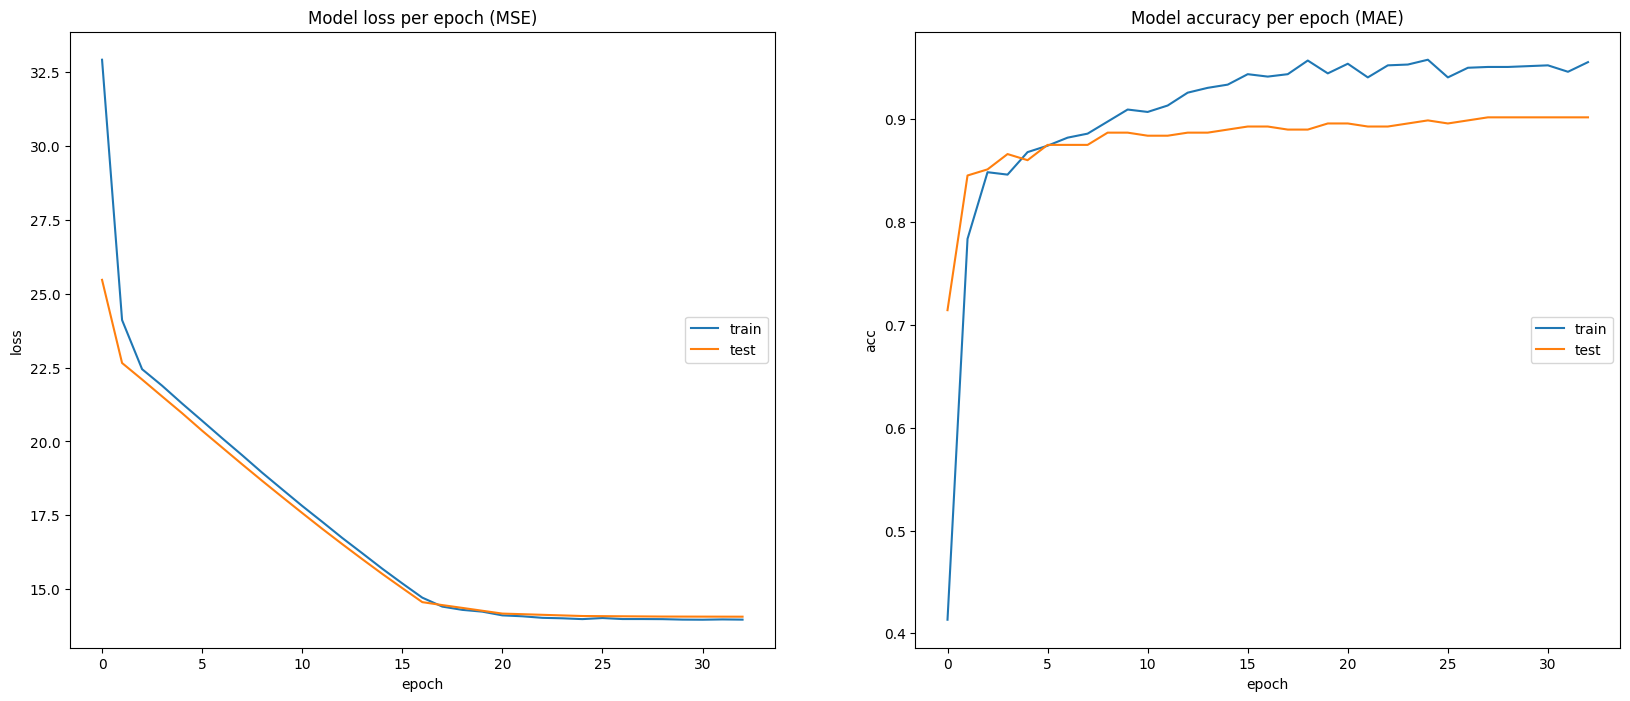

In [139]:
# Stockage historique d'évolution de la fonction de perte à chaque epoch
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Affichage de la courbe de la fonction de coût et de précision en fonction de l'epoch
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch (MAE)')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.show()

In [ ]:
model.save('mobilenetv2_model2.h5')